# Demonstrator for the "P-Sphere Hull" package v0.1

This notebook uses methods from the `refine_cluster_set` module and `PSphereHull` module to explore and visualize the high-dimensional topology of a real industrial dataset, and define a domain around the data that is topologically realistic and can easily be tested for membership.

__Warning__

This demonstrator uses a dataset derived from an old Tessella project. All values have been randomly perturbed, rescaled, 
and anonymized. Nevertheless, you should not share it with anyone outside Tessella. For context, the data represent six 
highly predictive variables for the efficiency of an energy distribution network.

__Basic approach__

The new package supports the following procedure to model the domain of a p-dimensional dataset:
1. Cluster the dataset with a high value of k (30 usually works well), using any appropriate method.
2. Choose a simple geometric surface to contain each cluster (p-sphere, p-cylinder, or hypercuboid). Each surface contains a hypervolume or subdomain that we consider part of the full domain.
3. Represent the domain as the collection of subdomains.
4. We presume that the ability of the model to make a "valid" prediction is limited to the regions contained by at least one subdomain, and also that the quality of the prediction can vary depending on the volume and density of the subdomain that contains the vector.

__Terminology__

The composite domain is called a *p-sphere hull*, and is modeled by the `PSphereHull` class. 
The sub-domains are generically called *p-spheres*, and they are modeled by the `PSphere` class.
A PSphereHull object contains a collection of PSphere objects. Note that the actual surfaces used
to model the subdomains can be either p-spheres or p-cylinders. (1)

__Advantages__

In practice, a machine learning model can save the p-sphere hull of its training data and *warn users* if it tries to make a prediction from a vector outside the hull. This is a more useful way of detecting model drift than tracking an aggregated performance metric. (2) 

The process also has an impact on cross-validation, in that sparsely populated parts of the domain are more likely to change their shape according to the train-test split. With the p-sphere hull, we can measure the performance of in-domain and ex-domain test data separately. We can also impose conditions on which sub-domains are used for training or applying the model, for example a density threshold on the p-spheres.

One of the main advantages that I see to this approach is that we can test membership in the p-sphere hull very quickly, adding no significant computational overhead to a machine learning application. (3)

__Short-term goals for version 0.2__

* Add a method to create the topological diagram of the hull (spheres connected by an edge if they share data)
* Add a radial density profile attribute to p-spheres and p-cylinders for better estimation of model quality.
* Add a wrapper class to train sklearn models alongside the p-sphere hull.
* Add a 'p-box hull' class for collections of hypercuboids and rotated hypercuboids.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Footnotes-to-the-Introduction" data-toc-modified-id="Footnotes-to-the-Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Footnotes to the Introduction</a></span></li><li><span><a href="#Load-and-Visualize-a-Dataset" data-toc-modified-id="Load-and-Visualize-a-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Visualize a Dataset</a></span></li><li><span><a href="#Cluster-the-Data-and-Refine-the-Cluster-Set" data-toc-modified-id="Cluster-the-Data-and-Refine-the-Cluster-Set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cluster the Data and Refine the Cluster Set</a></span><ul class="toc-item"><li><span><a href="#Widget-to-highlight-a-single-cluster" data-toc-modified-id="Widget-to-highlight-a-single-cluster-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Widget to highlight a single cluster</a></span></li><li><span><a href="#Compare-the-clusters-in-terms-of-volume-and-density" data-toc-modified-id="Compare-the-clusters-in-terms-of-volume-and-density-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compare the clusters in terms of volume and density</a></span></li><li><span><a href="#Improve-individual-clusters" data-toc-modified-id="Improve-individual-clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Improve individual clusters</a></span></li></ul></li><li><span><a href="#Make-the-P-Sphere-Hull" data-toc-modified-id="Make-the-P-Sphere-Hull-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make the P-Sphere Hull</a></span><ul class="toc-item"><li><span><a href="#Identify-and-mask-redundant-subdomains" data-toc-modified-id="Identify-and-mask-redundant-subdomains-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Identify and mask redundant subdomains</a></span></li><li><span><a href="#Widget-to-display-a-single-cluster-in-3-projections,-with-the-p-sphere-and-p-cylinder-enclosing-it" data-toc-modified-id="Widget-to-display-a-single-cluster-in-3-projections,-with-the-p-sphere-and-p-cylinder-enclosing-it-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Widget to display a single cluster in 3 projections, with the p-sphere and p-cylinder enclosing it</a></span></li><li><span><a href="#Test-whether-new-vectors-are-inside-the-dataset-domain" data-toc-modified-id="Test-whether-new-vectors-are-inside-the-dataset-domain-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test whether new vectors are inside the dataset domain</a></span></li><li><span><a href="#Use-p-sphere-density-as-a-proxy-for-prediction-quality" data-toc-modified-id="Use-p-sphere-density-as-a-proxy-for-prediction-quality-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Use p-sphere density as a proxy for prediction quality</a></span></li></ul></li><li><span><a href="#Machine-Learning-with-a-P-Sphere-Hull" data-toc-modified-id="Machine-Learning-with-a-P-Sphere-Hull-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Machine Learning with a P-Sphere Hull</a></span><ul class="toc-item"><li><span><a href="#Traditional-machine-learning-process" data-toc-modified-id="Traditional-machine-learning-process-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Traditional machine learning process</a></span></li><li><span><a href="#Build-a-hull-for-the-training-dataset" data-toc-modified-id="Build-a-hull-for-the-training-dataset-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Build a hull for the training dataset</a></span></li><li><span><a href="#Classification-results:-in-domain-vs-ex-domain-data" data-toc-modified-id="Classification-results:-in-domain-vs-ex-domain-data-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Classification results: in-domain vs ex-domain data</a></span></li><li><span><a href="#Regression-results:-in-domain-vs-ex-domain-data" data-toc-modified-id="Regression-results:-in-domain-vs-ex-domain-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Regression results: in-domain vs ex-domain data</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Footnotes to the Introduction

1. Just as a cylinder  is a circle that has been extended by a small amount in the 3rd dimension, a p-cylinder is a spherical surface that has been extended by small amounts in one or more perpendicular dimensions. When using p-cylinders, which is the default behavior, the `PSphere` class uses the PCA and SparsePCA algorithms to detect dimensions that are 'compact' and can be modeled as perpendicular extensions of a sphere. For example, if it detects 2 compact dimensions then the surface is a 4-sphere extended by small amounts into the other 2 dimensions. The algorithm to detect compact dimensions has only one tunable parameter: an explained variance threshold (default = 90%) for the principal components.

2. After a model is deployed, the number of points falling outside the training domain can start small but gradually increase as the model impacts the nature of the data being collected. In an aggregated performance metric, we might not see the impact of this drift for months, by which time many unreliable predictions will already have been made. If the model can emit individual warnings, however, then the growing stream of unreliable predictions will be very obvious.

3. We could also build the domain as a collection of convex hulls or PCA-rotated hypercuboids, 
but that would add significant overhead to the membership test. A future version of this package
will support PCA-rotated hypercuboids.

Developed using:
* sklearn version: 0.23.2
* numpy version 1.19.4
* pandas version 1.0.4
* matplotlib version 2.1.2
* ipywidgets version 7.5.1

In [1]:
%load_ext watermark
%watermark -v -p scikit-learn,numpy,pandas,matplotlib,ipywidgets

ModuleNotFoundError: No module named 'watermark'

In [2]:
%matplotlib inline

# import libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Interaction
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

# Scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import cluster

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import sklearn.metrics as metrics

In [8]:
# PSphereHull modules

# import PSphereHull package from local folder
import os
import sys
module_path = '../src'
if module_path not in sys.path:
    sys.path.append(module_path)

from PSphereHull import refine_cluster_set as rcs
from PSphereHull import psphere_hull as psh
from PSphereHull import basic_functions as bf

## Load and Visualize a Dataset

In [9]:
df = pd.read_csv('../data/anon_indust_dataset.csv', sep=';')
print(df.shape)
xcols = ['X0','X1','X2','X3','X4','X5']
data = df[xcols]
target = df['Y'].values
df.head()

(10881, 7)


,X0,X1,X2,X3,X4,X5,Y
0,-12.019242,-2.953112,-13.624557,-0.368324,-3.454812,1.626120,28.765432
1,-11.620635,-2.929634,-13.694241,-0.328900,-5.176406,1.002843,37.450980
2,-11.313086,-2.974976,-13.641401,-0.294004,-1.654922,2.344820,55.250000
3,-11.305471,-2.965242,-13.720973,-0.347593,-7.623290,2.728371,9.268293
4,-8.820984,-2.990580,-13.721199,-0.369271,-4.122204,2.120711,27.209302


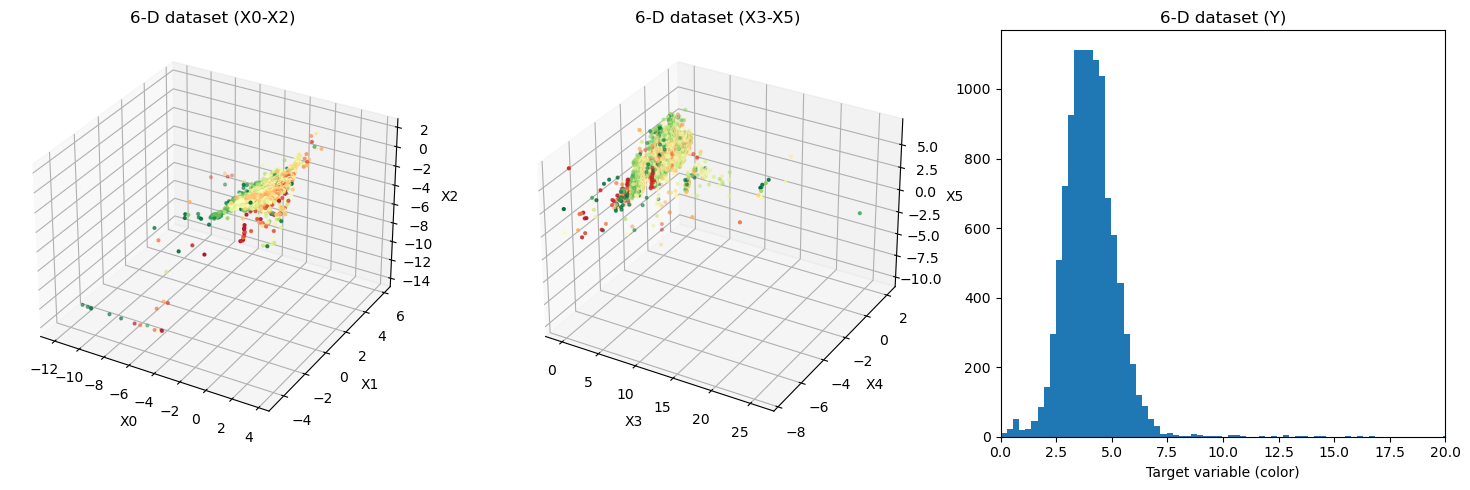

In [10]:
# plot the dataset as two 3D projections and the target variable
colormap = cm.RdYlGn #or any other colormap
normalize = colors.Normalize(vmin=0.01, vmax=7.5)
# Plot 3 3D projections of the data
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')
ax.set_title('6-D dataset (X0-X2)')
ax.scatter(data.values[:,0],data.values[:,1],data.values[:,2], s=4, 
           c=target, cmap=colormap, norm=normalize)

ax = fig.add_subplot(132, projection='3d')
ax.set_xlabel('X3')
ax.set_ylabel('X4')
ax.set_zlabel('X5')
ax.set_title('6-D dataset (X3-X5)')
ax.scatter(data.values[:,3],data.values[:,4],data.values[:,5], s=4,
          c=target, cmap=colormap, norm=normalize)

ax = fig.add_subplot(133)
ax.hist(target,bins=200)
ax.set_xlabel('Target variable (color)')
ax.set_title('6-D dataset (Y)')
ax.set_xlim((0,20))

fig.tight_layout()
#fig.savefig('6D_industrial_dataset_with_target.png')

## Cluster the Data and Refine the Cluster Set

The end goal of this process is to find a "balanced" set of clusters whose bounding surfaces do not contain much excess
hypervolume. Specifically, the default behavior is to create a collection of p-cylinders that combine to make the 
"p-sphere hull" of the whole dataset.

In practice, the package `refine_cluster_set` provides a set of tools that you can use to compare the clusters, identifying
those which are very sparse or low-dimensional with respect to the feature space, and modify the cluster by splitting them,
fusing them, or removing outliers that inflate the volume.

The new package is agnostic to the clustering method used on the data. The methods in this package
only take the dataset, cluster labels, and cluster centers as inputs, not the trained model. 
Here, we apply the `StandardScaler()` transform to the data then use `KMeans(30)` to find the initial cluster set.   

Note that K-means is used by the `rcs.split_cluster()` method to divide a large cluster into 2 smaller clusters.

In [28]:
# K-means or any other method
scaled_data = data.values
n_clusters = 30
km = cluster.KMeans(n_clusters, random_state=42)
km.fit(scaled_data)

C:\Users\hruedari\AppData\Local\miniconda3\envs\fox\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=30, random_state=42)

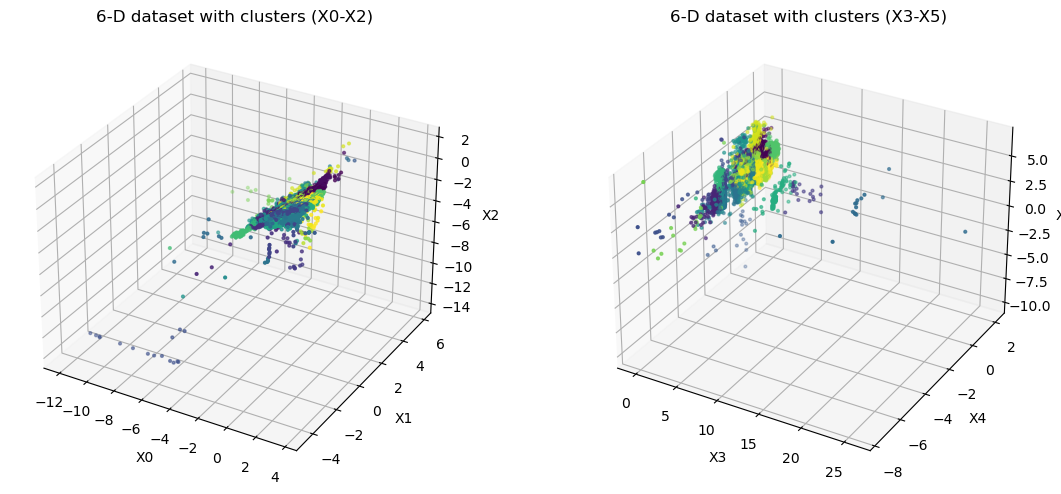

In [12]:
# A pair of 3D plots where color indicates cluster membership
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')
ax.set_title('6-D dataset with clusters (X0-X2)')
ax.scatter(scaled_data[:,0], scaled_data[:,1], scaled_data[:,2], s=4, c=km.labels_)
ax = fig.add_subplot(122, projection='3d')
ax.set_xlabel('X3')
ax.set_ylabel('X4')
ax.set_zlabel('X5')
ax.set_title('6-D dataset with clusters (X3-X5)')
ax.scatter(scaled_data[:,3], scaled_data[:,4], scaled_data[:,5], s=4, c=km.labels_)
fig.tight_layout()
#fig.savefig('6D_industrial_dataset_initial_clustering.png') 

### Widget to highlight a single cluster

Clusters 12 and 14 give a a nice demonstration of how points can be "close together" in one projection 
but "dispersed" in another

In [10]:
# define display_cluster() function for widget
cols_to_keep = data.columns.tolist()
def display_cluster(cluster_id):
    fig = plt.figure(figsize=(12,5))
    ic_colors = np.where(km.labels_ == cluster_id, 'red', 'grey')
    ic_sizes = np.where(km.labels_ == cluster_id, 9, 1)
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlabel(cols_to_keep[0][6:])
    ax.set_ylabel(cols_to_keep[1][6:])
    ax.set_zlabel(cols_to_keep[2][6:])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,0],scaled_data[:,1],scaled_data[:,2], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(122, projection='3d')
    ax.set_xlabel(cols_to_keep[3][6:])
    ax.set_ylabel(cols_to_keep[4][6:])
    ax.set_zlabel(cols_to_keep[5][6:])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,3],scaled_data[:,4],scaled_data[:,5], s=ic_sizes,
              c=ic_colors)
    fig.tight_layout()
    plt.show()
    return

In [11]:
inbox = widgets.BoundedIntText(value=0, min=0, max=n_clusters-1, description='Cluster ID:')
ui = widgets.HBox([inbox])
# cluster_id is the name of an argument to f()
out = widgets.interactive_output(display_cluster, {'cluster_id': inbox})
display(ui,out);

Output()

### Compare the clusters in terms of volume and density

The first method we want to use from `refine_cluster_set` is `rcs.describe_cluster_pspheres()`. It generates a pandas dataframe of useful statistics to compare the clusters and help us decide which ones might need adjusting.

For each cluster, it finds the p-box (a hypercuboid) and p-cylinder (p-sphere X p-box) that surround its data, then calculates the volume of the shape and the density of data within. It also uses Principal Component Analysis to calculate the 'local
dimensionality' of the data manifold: the number of principal components that explain 90% of the variance.

The columns of the dataframe are:
* ndata: number of data points in cluster
* localdim: number of principal components that explain pct_threshold of cluster variance
* ps_volume: hypervolume inside the p-cylinder bounding the cluster
* ps_vratio: ps_volume / full dataset hypervolume
* ps_density: ndata / ps_volume
* hc_volume: hypervolume inside the p-box bounding the cluster 
* hc_vratio: hc_volume / full dataset hypervolume
* hc_density: ndata / hc_volume
* ps_to_hc: ps_volume / hc_volume

In [13]:
spheres_df = rcs.describe_cluster_pspheres(scaled_data, km.labels_, km.cluster_centers_)

# Alternatively, you can calculate p-sphere volumes instead of p-cylinder volumes:

#spheres_df = rcs.describe_cluster_pspheres(scaled_data, km.labels_, km.cluster_centers_, use_pcylinders=False)
spheres_df

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
0,623,4,2.667643,1.862365e+03,0.000162,0.334521,56.646406,4.928027e-06,10.998050,32.877021
1,402,4,3.121153,4.777367e+03,0.000416,0.084147,108.641510,9.451407e-06,3.700243,43.973679
2,638,4,2.486640,4.720736e+02,0.000041,1.351484,37.801701,3.288607e-06,16.877547,12.488158
3,285,4,5.189298,1.009137e+05,0.008779,0.002824,919.049779,7.995391e-05,0.310103,109.802163
4,180,4,3.417656,2.008900e+03,0.000175,0.089601,137.026836,1.192082e-05,1.313611,14.660628
5,22,2,3.427989,4.841258e+03,0.000421,0.004544,235.743927,2.050884e-05,0.093322,20.536086
6,328,4,4.337258,6.610348e+03,0.000575,0.049619,292.592970,2.545450e-05,1.121011,22.592299
7,16,2,6.173195,9.855493e+01,0.000009,0.162346,10.640542,9.256876e-07,1.503683,9.262210
8,18,3,5.612085,2.901245e+03,0.000252,0.006204,214.514505,1.866196e-05,0.083910,13.524702


After creating the dataframe with `rcs.describe_cluster_pspheres()`, the method `rcs.plot_cluster_pspheres()` lets you
produce log-log plots of the cluster statistics. This plot highlight clusters that are large and sparse or low-dimensional.

The sizes of the markers are scaled so that area is proportional to ndata. The colors of the markers indicate the local dimensionality of the cluster: red for 1D, orange for 2D, and so on.

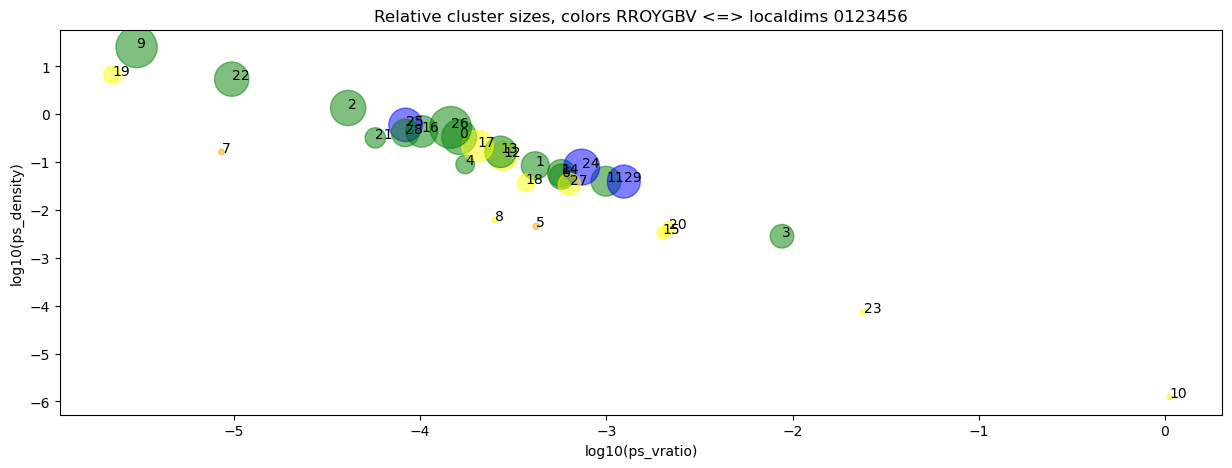

In [14]:
rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density')

# Alternatively, add a filename argument to save the figure:

#fig_title = '6D_industrial_dataset_initial_pspheres_plot.png'
#rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density', filename=fig_title)

By looking at this plot, we can see immediately which clusters are likely to contain a lot of wasted volume. If the 
local dimension of a cluster is much less than $p$ (for example, a linear cluster in a 4D space) then the bounding 
surface contains a lot of wasted space and does not represent well the cluster shape. Using p-cylinders instead of 
p-spheres (the default behavior) alleviates this problem somewhat. Linear clusters can also be split (see below).

Another common feature highlighted by this plot is that some clusters are large and sparse (lower right region of the plot).
In some cases, the hypervolume of the p-sphere bounding a cluster can even be larger than the hypercuboid that bounds the 
full dataset! 

### Improve individual clusters

We want to improve the clustering solution by reducing the wasted hypervolume in the p-cylinders that will represent subdomains of the dataset.

A sparse cluster may be "improved" by two methods: 
* `rcs.flag_outlier()` removes the data point with the largest radius by changing its cluster label to -1
* `rcs.split_cluster()` using KMeans(2) to create two subclusters
The list of labels and cluster centers is updated accordingly; you can end up with more clusters than you started with.

For the sake of symmetry, there is also a method `rcs.fuse_clusters()` that you can use if you notice two compact clusters
that are very close together. However, `split_cluster` and `fuse_clusters` are not reciprocal operations because the process of splitting has a random element.

The following cells describe my own decision process to refine the cluster set.

__Cluster 15 is small and sparse__

The obvious danger is that cluster 15 needs a bounding surface with a very large hypervolume. The value of log10(ps_vratio) is approximately zero, meaning that the p-cylinder volume is as large as the hypercuboid volume of the full dataset!

Cluster 15 has only 15 data points, and looking at the widget we can see that it has one or two obvious outlier in the two 3D projections. So let us try to split it into two subclusters, and if that fails remove the outliers.

Note that the first function call of split_cluster uses the original K-means labels and centers, but the following operations
rewrite the variables new_labels and new_centers.

In [16]:
cid = 10
new_labels, new_centers, success = rcs.split_cluster(scaled_data, km.labels_, km.cluster_centers_, cid, min_size=4, verbose=True)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
print(new_centers.shape)

C:\Users\hruedari\AppData\Local\miniconda3\envs\fox\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hruedari\AppData\Local\miniconda3\envs\fox\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


......cluster 10 not split because child size < min_size
(30, 6)


__Cluster 25 is small and sparse__

The next sparsest cluster is number 25, which also has 2 outliers visible in the 3D projections. These outliers greatly increase the enclosed volume.

In [15]:
cid = 25
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, cid, min_size=4, verbose=True)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
print(new_centers.shape)

......cluster 25 split successfully
(31, 6)


__Clusters 12 and 6 are 2-dimensional__

Examining both these clusters in the widget, we see that number 12 is already compact and contains few datapoints. On the other hand, the fact that its local dimensionality is only 2 implies that bounding it with a 6D p-sphere is very wasteful in terms of defining a hull. 

Cluster 6, on the other hand, is widely scattered and includes the linear set of points that lies well 
outside the main grouping. We can try to split it, but there is no guarantee that we capture the best configuration. It 
probably makes more sense to reassign the points to subclusters by hand.

In [16]:
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, 12, verbose=True)
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, 6, verbose=True)
print(new_centers.shape)

......cluster 12 split successfully
......cluster 6 not split because child size < min_size
(32, 6)


__Clusters with large volumes__

Finally, a few clusters have exceptionally large volumes so are worth a closer look.
* Cluster 16 looks bimodal or trimodal
* Cluster 4 has 2 possible outliers
* Cluster 17 has one obvious outlier
* Cluster 18 looks like it has one outlier
* Cluster 29 has one obvious outlier

In [17]:
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, 16, verbose=True)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 29)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 18)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 17)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 4)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 4)

......cluster 16 split successfully


Let's look at the new set of clusters. Notice that we now have 33 clusters since some were split successfully.
The hypervolumes of all the modified clusters are now much smaller.

The solution is not perfect: cluster 15 is still unusually sparse, and cluster 6 still contains the strange linear series of
points. Both clusters lie well outside the main grouping, but on the other hand the engineers told us that these points are
valid data for the system being studied. Perhaps they represent transient behaviors between distinct stable states.

We can show these clusters to the domain experts and decide together whether to include them in the training data or mask them. The `PSphereHull` class, which we will demonstrate next, allows us to easily make either decision, by setting the boolean atrribute 'used' for a single cluster's domain. 

In [17]:
spheres_df = rcs.describe_cluster_pspheres(scaled_data, new_labels, new_centers)
spheres_df

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
0,623,4,2.667643,1862.365096,0.000162,0.334521,56.646406,4.928027e-06,10.998050,32.877021
1,402,4,3.121153,4777.366898,0.000416,0.084147,108.641510,9.451407e-06,3.700243,43.973679
2,638,4,2.486640,472.073606,0.000041,1.351484,37.801701,3.288607e-06,16.877547,12.488158
3,285,4,5.189298,100913.653378,0.008779,0.002824,919.049779,7.995391e-05,0.310103,109.802163
4,180,4,3.417656,2008.899516,0.000175,0.089601,137.026836,1.192082e-05,1.313611,14.660628
5,22,2,3.427989,4841.257592,0.000421,0.004544,235.743927,2.050884e-05,0.093322,20.536086
6,328,4,4.337258,6610.347885,0.000575,0.049619,292.592970,2.545450e-05,1.121011,22.592299
7,16,2,6.173195,98.554932,0.000009,0.162346,10.640542,9.256876e-07,1.503683,9.262210
8,18,3,5.612085,2901.244842,0.000252,0.006204,214.514505,1.866196e-05,0.083910,13.524702


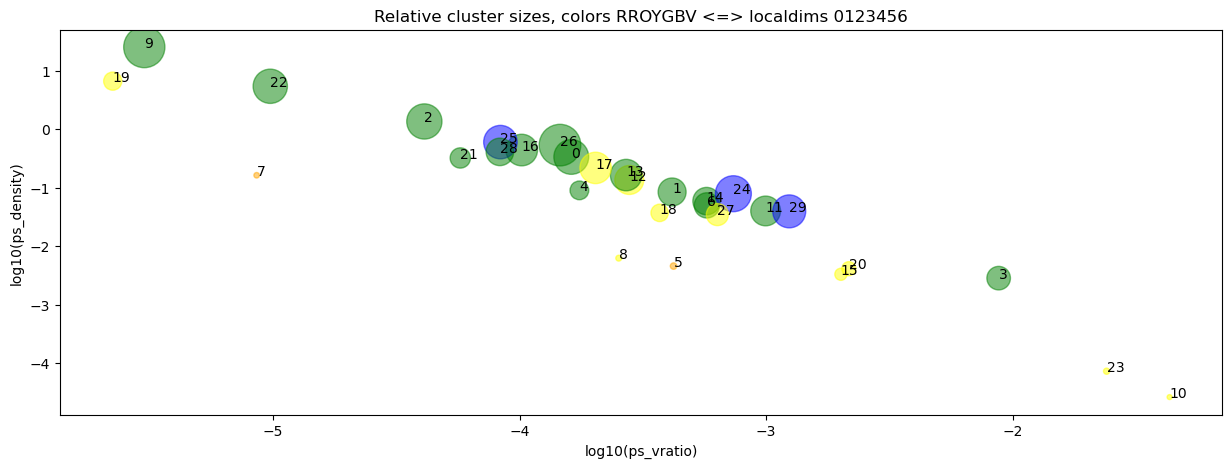

In [18]:
rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density')

In [19]:
# define display_new_cluster() function for the widget
def display_new_cluster(cluster_id):
    fig = plt.figure(figsize=(12,5))
    ic_colors = np.where(new_labels == cluster_id, 'red', 'grey')
    ic_sizes = np.where(new_labels == cluster_id, 9, 1)
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlabel(cols_to_keep[0][6:])
    ax.set_ylabel(cols_to_keep[1][6:])
    ax.set_zlabel(cols_to_keep[2][6:])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,0],scaled_data[:,1],scaled_data[:,2], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(122, projection='3d')
    ax.set_xlabel(cols_to_keep[3][6:])
    ax.set_ylabel(cols_to_keep[4][6:])
    ax.set_zlabel(cols_to_keep[5][6:])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,3],scaled_data[:,4],scaled_data[:,5], s=ic_sizes,
              c=ic_colors)
    fig.tight_layout()
    plt.show()
    return

In [21]:
inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
# cluster_id is the name of an argument to f()
out = widgets.interactive_output(display_new_cluster, {'cluster_id': inbox})
display(ui,out);

Output()

## Make the P-Sphere Hull

The `PSphereHull` class creates a collection of p-cylinders (default behavior) or p-spheres from a clustering solution: the dataset, the cluster labels, and the cluster centers.

Once the hull is created, several methods are immediately available to test whether a new point is contained in the hull or not. This test is very fast, since the new point is contained by the hull if it is contained in any subdomain. The main advantage of
using p-spheres and p-cylinders is that the mathematical operations needed to test containment are very cheap.

*Note: We could create a "p-box hull" of the hypercuboid subdomains with even less wasted volume. However, then many more points in the dataset would be on the domain boundary and the hull would be less useful overall in an industrial setting where the data are expected to be noisy. I consider p-cylinders to be a good compromise between limiting the enclosed volume while giving the dataset hull a reasonable probability to include noisy and new data.*

In [20]:
%%time
hull = psh.PSphereHull(scaled_data, new_labels, new_centers, compute_all=True)

CPU times: total: 3min 29s
Wall time: 3min 31s


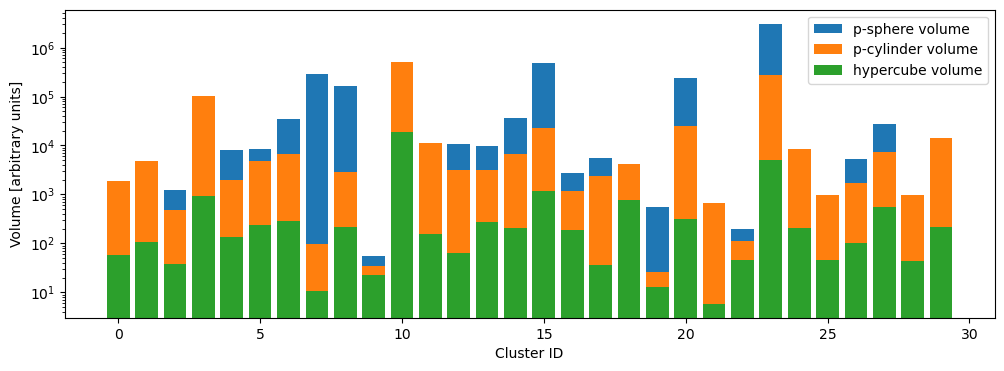

In [21]:
# Plot of p-sphere, p-cylinder, and hypercuboid volumes for the final clustering solution.
labels = [s.label for s in hull.spheres]
vols = [s.volume for s in hull.spheres]
pvols = [s.pcylinder_vol for s in hull.spheres]
hcvols = spheres_df['hc_volume'].values.tolist()
fig = plt.figure(figsize=(12,4))
p1 = plt.bar(labels, vols, log=True)
p2 = plt.bar(labels, pvols, log=True)
p3 = plt.bar(labels, hcvols, log=True)
plt.ylabel('Volume [arbitrary units]')
plt.xlabel('Cluster ID')
plt.legend((p1[0], p2[0], p3[0]), ('p-sphere volume', 'p-cylinder volume', 'hypercube volume'));
#fig.savefig('6D_industrial_dataset_pcylinder_volumes.png')

The following cell shows the 'naive' volume calculation for the whole dataset, which just sums up the volumes of the subdomains while ignoring the fact that many of them overlap. It also shows the 'sampled' volume calculation, which generates random points in the full dataset hypercuboid and reports the fraction that fall inside the hull. The `compute_all` argument above tells the constructor
to calculate both volumes automatically, but you can use the hull without this calculation.

The results show that the p-sphere hull is a much better representation of the data domain than the hypercuboid hull (which is generally the default representation even in industrialized models).

In [22]:
# Display volume ratios for the whole dataset
print('Full dataset hypercube volume:', round(hull.hc_volume,1))
print('Naïve p-sphere vol. ratio: {:6.4f}'.format(hull.naive_vratio))
print('Sampled p-sphere vol. ratio: {:6.4f} +/- {:6.4f}'.format(hull.sampled_vratio,
                                                                 hull.sampled_vratio_sigma))
print('---')
print('Naïve p-yclinder vol. ratio: {:6.4f}'.format(hull.naive_pcylinder_vratio))
print('Sampled p-cylinder vol. ratio: {:6.4f} +/- {:6.4f}'.format(hull.sampled_pcylinder_vratio,
                                                                 hull.sampled_pcylinder_vratio_sigma))

Full dataset hypercube volume: 10828569.3
Naïve p-sphere vol. ratio: 0.4650
Sampled p-sphere vol. ratio: 0.1410 +/- 0.0119
---
Naïve p-yclinder vol. ratio: 0.0936
Sampled p-cylinder vol. ratio: 0.0370 +/- 0.0061


### Identify and mask redundant subdomains

Many of the clusters have no 'unique' data : every point in the cluster is contained in at least one other cluster's domain. We can represent the hull and test for membership more efficiently if we mask the redundant p-cylinders.

Adding the flag `compute_all=True` to the PSphereHull constructor will cause it to mask redundant spheres automatically.

In [23]:
%%time
hull.flag_redundant_spheres()
print('Hull is now using spheres:')
for s in hull.spheres:
    if s.used:
        print (s.label, end=' ')

Hull is now using spheres:
5 6 7 8 10 18 19 20 23 27 29 CPU times: total: 3min 10s
Wall time: 3min 17s


Recall that we removed seven 'outliers' to prevent some of the p-cylinders from growing too large. Some of these are visible in the plot below.

The code for the plot makes use of the method `rcs.pcylinder_patch`, which returns a circle or rectangle pyplot artist patch, as needed for the 2D cross-section of the p-cylinder.

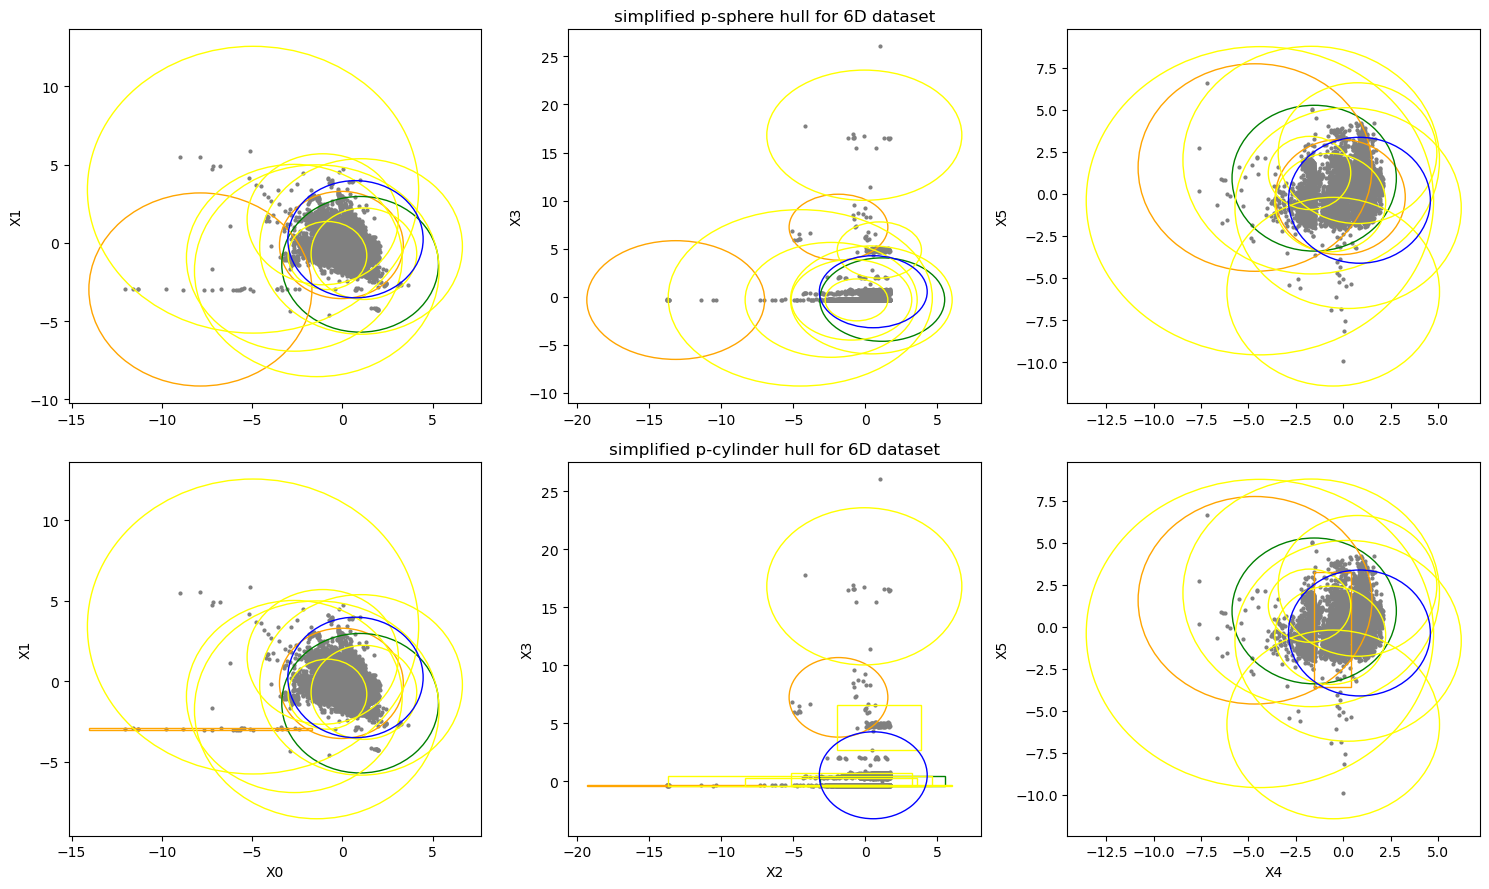

In [24]:
# Code to draw the hull in three 2D projections, using only non-redundant domains
fig = plt.figure(figsize=(15,9))
idx = [[0,1],[2,3],[4,5]]
dim_map = {1:'red', 2:'orange', 3:'yellow', 4:'green', 5:'blue', 6:'purple', 7:'black', 8:'black', 9:'black'}
clus_cols = [dim_map[i] for i in hull.localdims]

for iax in range(3):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(231 + iax)
    #ax.set_xlabel('X'+str(idx1))
    ax.set_ylabel('X'+str(idx2))
    ax.scatter(scaled_data[:,idx1], scaled_data[:,idx2], s=4, c='grey')
    for k in range(hull.n_spheres):
        if hull.spheres[k].used:
            circ = plt.Circle((hull.spheres[k].center[idx1], hull.spheres[k].center[idx2]),
                              radius=hull.spheres[k].radius, color=clus_cols[k], fill=False)
            ax.add_patch(circ)
    if iax == 1:
        ax.set_title('simplified p-sphere hull for 6D dataset')

for iax in range(3):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(234 + iax)
    ax.set_xlabel('X'+str(idx1))
    ax.set_ylabel('X'+str(idx2))
    ax.scatter(scaled_data[:,idx1], scaled_data[:,idx2], s=4, c='grey')
    for k in range(hull.n_spheres):
        if hull.spheres[k].used:
            cyl, rect = rcs.pcylinder_patch(idx1, idx2, hull.spheres[k].center, hull.spheres[k].radius,
                                            hull.spheres[k].compact_dims, hull.spheres[k].compact_ranges, color=clus_cols[k])
            ax.add_patch(cyl)
    if iax == 1:
        ax.set_title('simplified p-cylinder hull for 6D dataset')
fig.tight_layout()        
#fig.savefig('6D_industrial_dataset_pspheres_redundant_masked.png')

### Widget to display a single cluster in 3 projections, with the p-sphere and p-cylinder enclosing it

In [27]:
# code to prepare the widget
axmin = []
axmax = []
for icol in range(6):
    axmin.append(np.min(scaled_data[:,icol])-0.3)
    axmax.append(np.max(scaled_data[:,icol])+0.3)
lims = list(zip(axmin,axmax))

def display_cluster_projections(cid):
    fig = plt.figure(figsize=(14,4))
    for iax in range(3):
        ix = iax * 2
        iy = iax * 2 + 1
        ax = fig.add_subplot(131+iax)
        ax.set_xlim(lims[ix])
        ax.set_ylim(lims[iy])
        c_rows = np.where(new_labels==cid)[0]
        ax.scatter(scaled_data[c_rows,ix],scaled_data[c_rows,iy],s=25,marker='x',color='black',lw=0.5)
        circ = plt.Circle((hull.spheres[cid].center[ix], hull.spheres[cid].center[iy]),
                              radius=hull.spheres[cid].radius, color=clus_cols[cid], fill=False)
        cyl, rect = rcs.pcylinder_patch(ix, iy, hull.spheres[cid].center, hull.spheres[cid].radius, hull.spheres[cid].compact_dims,
                              hull.spheres[cid].compact_ranges, color='black')
        if rect: 
            ax.add_patch(cyl)
        ax.add_patch(circ)
        ax.set_title('Cluster '+str(cid))
        ax.set_xlabel('X'+str(ix))
        ax.set_ylabel('X'+str(iy))
    plt.show()
    return

inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
out = widgets.interactive_output(display_cluster_projections, {'cid': inbox})
display(ui,out);

Output()

### Test whether new vectors are inside the dataset domain

The p-sphere hull is now a useful geometric representation of the dataset domain.

The method `hull.contains()` takes a single vector or array of vectors and tests whether they are inside any of the hull subdomains.

In [28]:
# Generate 500 random data points inside the hypercuboid of the full dataset
np.random.seed(42)
newdata = np.zeros(500*hull.pdim).reshape((500,hull.pdim))
for idx in range(hull.pdim):
    scale = hull.hc_max[idx] - hull.hc_min[idx]
    offset = hull.hc_min[idx]
    newdata[:,idx] = (np.random.rand(500)*scale) + offset
print('newdata has shape',newdata.shape)
print('example vector:')
print(newdata[0,:])

newdata has shape (500, 6)
example vector:
[ -6.15611967   2.71580032 -10.9195961   13.34282218  -5.08368931
   3.76572793]


In [25]:
point_in_hull = hull.contains(scaled_data)
points_inside = np.where(point_in_hull)[0]
points_outside = np.where(point_in_hull==False)[0]
print('The new data points that are inside the hull have indices:')
print(points_inside)

The new data points that are inside the hull have indices:
[    0     1     2 ... 10878 10879 10880]


In [27]:
len(points_inside)/len(scaled_data)

0.9995404834114512

You can also measure the distances of points from each sphere in the hull. A value of zero indicates that the point is inside the sphere.

The method used here is `PSphereHull.psphere_distances(data)`. The row vectors of data are N new data points, and it returns a matrix with dimension N x k where k is the number of p-spheres in the hull.
Hence, the value of distances[i,j] is the distance of vector i from p-sphere j.

In [30]:
distances = hull.psphere_distances(newdata)
outside_min_distances = np.min(distances[points_outside,:], axis=1)
print('P-sphere distances for first vector in newdata:')
print(distances[0])
print('Minimum distances for vectors inside the hull:')
print(np.min(distances[points_inside,:], axis=1))

P-sphere distances for first vector in newdata:
[12.52428389 12.79454212  3.05543763 12.79873808 15.08982805 11.50748185
  5.62300345 12.62143195 18.47891028 12.92473905 12.7868028  18.06307929
  6.36869601 12.89465854 12.682936    6.89933094 13.6136822  13.09128806
 12.90566039 11.33914108 12.63800285 12.68519262 17.36291523 18.15864347
 12.72621646 13.89805065 13.61448789 16.5146492  16.24824573 13.61370634
  1.42699281  2.6019202  18.96621841]
Minimum distances for vectors inside the hull:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


We can use the matrix of distances to determine whether a new data point is close to the hull.

Text(0.5, 1.0, 'Minimum distances <= 1')

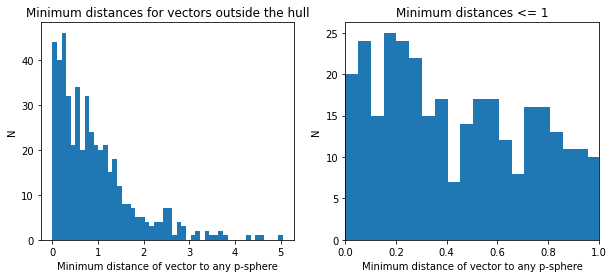

In [31]:
# Code to generate figure
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.hist(outside_min_distances,bins=50);
ax1.set_xlabel('Minimum distance of vector to any p-sphere')
ax1.set_ylabel('N')
ax1.set_title('Minimum distances for vectors outside the hull')
ax2 = fig.add_subplot(122)
ax2.hist(outside_min_distances,bins=100);
ax2.set_xlabel('Minimum distance of vector to any p-sphere')
ax2.set_xlim((0,1))
ax2.set_ylabel('N')
ax2.set_title('Minimum distances <= 1')

### Use p-sphere density as a proxy for prediction quality

As we saw at the beginning of this demo, each p-sphere has a different data density. It stands to reason that a prediction whose vector is inside a small, densely populated p-sphere will be more reliable than one inside a large, sparse p-sphere.

In this example, we see that most of the new vectors fall inside sphere 15, which is the largest and
sparsest component of the hull. Therefore, their predictions are probably not very reliable. 
The vector with index 2 is in a densely populated region, belonging to many p-cylinders some of which are very dense.
It is also likely that the vector with index 196 (contained in
p-cylinders 13 and 18) has a reliable prediction.

The relationship between the density of the p-sphere and the quality of the prediction is of course something that must be determined separately for each application. But PSphereHull gives you the tools to determine this relationship during the normal
course of model training and validation.

In [32]:
print('Indices of vectors inside the hull:')
print(points_inside)
print('Vector index, containing sphere label(s), & containing sphere densities:')
spheres_set = set()
for idx in points_inside:
    vector = newdata[idx,:]
    containing_spheres = hull.find_containing_spheres(vector)
    spheres_set.update(set(containing_spheres))
    densities = [hull.spheres[s].ndata / hull.spheres[s].pcylinder_vol for s in containing_spheres]
    print(idx, containing_spheres, densities)

Indices of vectors inside the hull:
[  2 120 142 160 163 196 301 322 331 363 388 395 415 444 452 464]
Vector index, containing sphere label(s), & containing sphere densities:
2 (5, 7, 13, 18, 20, 21, 27) [0.12582514675682124, 0.17191998667175826, 0.04926621093456769, 0.0031815555793276644, 0.03454084727611295, 0.2783135835594315, 0.07979556225499042]
120 (15,) [2.6095528750546375e-05]
142 (15,) [2.6095528750546375e-05]
160 (15,) [2.6095528750546375e-05]
163 (15,) [2.6095528750546375e-05]
196 (13, 18) [0.04926621093456769, 0.0031815555793276644]
301 (15,) [2.6095528750546375e-05]
322 (15,) [2.6095528750546375e-05]
331 (15,) [2.6095528750546375e-05]
363 (15,) [2.6095528750546375e-05]
388 (15,) [2.6095528750546375e-05]
395 (15,) [2.6095528750546375e-05]
415 (15,) [2.6095528750546375e-05]
444 (15,) [2.6095528750546375e-05]
452 (15,) [2.6095528750546375e-05]
464 (15,) [2.6095528750546375e-05]


In [33]:
# Dataframe for the p-spheres containing the new data.
spheres_df.loc[list(spheres_set)]

,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
5,631,5,3.635468,5014.895800,0.000436,0.125825,210.771087,0.000018,2.993769,23.793092
7,564,4,3.559483,3280.595880,0.000285,0.171920,290.418489,0.000025,1.942025,11.296099
13,325,4,4.335429,6596.813391,0.000574,0.049266,292.592970,0.000025,1.110758,22.546042
15,13,3,6.771421,498169.633743,0.043339,0.000026,18637.405185,0.001621,0.000698,26.729560
18,76,3,5.622471,23887.685789,0.002078,0.003182,500.398959,0.000044,0.151879,47.737281
20,251,3,4.185067,7266.758629,0.000632,0.034541,577.711551,0.000050,0.434473,12.578524
21,566,4,3.273348,2033.677238,0.000177,0.278314,98.066649,0.000009,5.771585,20.737705
27,688,5,3.443911,8622.033363,0.000750,0.079796,224.685777,0.000020,3.062054,38.373739


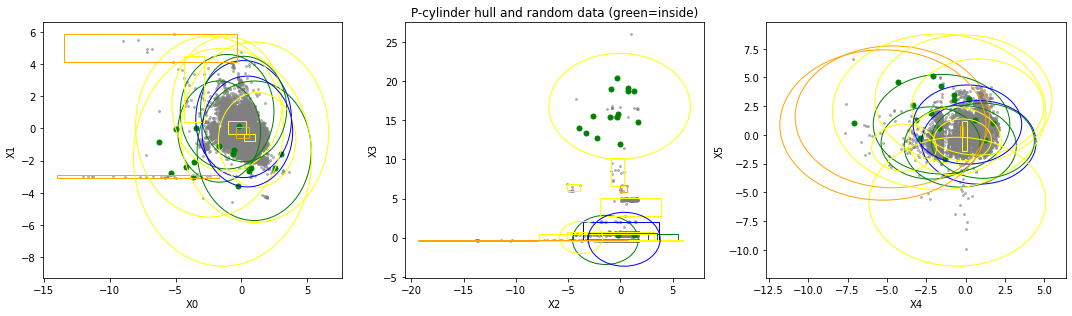

In [34]:
# Code to draw the hull in three 2D projections, using only non-redundant domains
fig = plt.figure(figsize=(15,4.5))
idx = [[0,1],[2,3],[4,5]]

for iax in range(3):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(131 + iax)
    ax.set_xlabel('X'+str(idx1))
    ax.set_ylabel('X'+str(idx2))
    ax.scatter(scaled_data[:,idx1], scaled_data[:,idx2], s=4, c='grey', alpha=0.5)
    ax.scatter(newdata[points_inside,idx1], newdata[points_inside,idx2], s=25, c='green')
    #ax.scatter(newdata[points_outside,idx1], newdata[points_outside,idx2], s=1, c='black')
    for k in range(hull.n_spheres):
        if hull.spheres[k].used:
            cyl, rect = rcs.pcylinder_patch(idx1, idx2, hull.spheres[k].center, hull.spheres[k].radius,
                                            hull.spheres[k].compact_dims, hull.spheres[k].compact_ranges, color=clus_cols[k])
            ax.add_patch(cyl)
    if iax == 1:
        ax.set_title('P-cylinder hull and random data (green=inside)')
fig.tight_layout()        

## Machine Learning with a P-Sphere Hull

### Traditional machine learning process

In [35]:
X = data.values
yclass = np.where(target >= 3.5, 1, 0)
z = target
# Random split
#Xtrain, Xtest, ytrain, ytest = train_test_split(data.values, yclass, train_size=0.8, random_state=42)
# Time split
idx_split = 8000
Xtrain = X[:idx_split,:]
Xtest = X[idx_split:-1,:]
ytrain = yclass[:idx_split]
ytest = yclass[idx_split:-1]
ztrain = z[:idx_split]
ztest = z[idx_split:-1]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
cmodel = RandomForestClassifier(n_estimators=20, max_depth=None, n_jobs=3, random_state=42)
cmodel.fit(Xtrain, ytrain)
ypred = cmodel.predict(Xtest)
f1 = metrics.f1_score(ytest,ypred)
print('RF Classifier F1 score:', f1)

rmodel = RandomForestRegressor(n_estimators=20, max_depth=None, n_jobs=3, random_state=42)
rmodel.fit(Xtrain, ztrain)
zpred = rmodel.predict(Xtest)
mae = metrics.mean_absolute_error(ztest,zpred)
print('RF Regressor MAE score:', mae)

(8000, 6) (2880, 6) (8000,) (2880,)
RF Classifier F1 score: 0.8379293662312531
RF Regressor MAE score: 1.2264734608074606


### Build a hull for the training dataset

Now let's examine the same machine learning problem from a different angle using the P-Sphere Hull.

First, we create a domain model for the training data. We reduce the number of clusters since we reduced the size of 
the dataset by 20%.

In [36]:
train_km = cluster.KMeans(20, random_state=99)
train_km.fit(Xtrain)
pspheres_df = rcs.describe_cluster_pspheres(Xtrain, train_km.labels_, train_km.cluster_centers_)

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


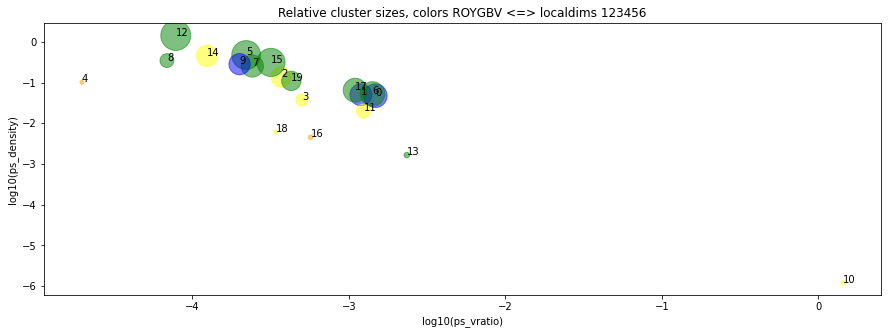

In [37]:
rcs.plot_cluster_pspheres(pspheres_df, 6, 'ps_vratio', 'ps_density')

We see that cluster 10 has a very large volume.

In [38]:
# code to prepare the widget
axmin = []
axmax = []
for icol in range(6):
    axmin.append(np.min(Xtrain[:,icol])-0.3)
    axmax.append(np.max(Xtrain[:,icol])+0.3)
lims = list(zip(axmin,axmax))
temp_hull = psh.PSphereHull(Xtrain, train_km.labels_, train_km.cluster_centers_)

def display_cluster_projections(cid):
    fig = plt.figure(figsize=(14,4))
    for iax in range(3):
        ix = iax * 2
        iy = iax * 2 + 1
        ax = fig.add_subplot(131+iax)
        ax.set_xlim(lims[ix])
        ax.set_ylim(lims[iy])
        c_rows = np.where(train_km.labels_==cid)[0]
        ax.scatter(Xtrain[c_rows,ix],Xtrain[c_rows,iy],s=25,marker='x',color='black',lw=0.5)
        circ = plt.Circle((temp_hull.spheres[cid].center[ix], temp_hull.spheres[cid].center[iy]),
                              radius=temp_hull.spheres[cid].radius, color=clus_cols[cid], fill=False)
        cyl, rect = rcs.pcylinder_patch(ix, iy, temp_hull.spheres[cid].center, temp_hull.spheres[cid].radius, 
                                        temp_hull.spheres[cid].compact_dims, temp_hull.spheres[cid].compact_ranges, color='black')
        if rect: 
            ax.add_patch(cyl)
        ax.add_patch(circ)
        ax.set_title('Cluster '+str(cid))
        ax.set_xlabel('X'+str(ix))
        ax.set_ylabel('X'+str(iy))
    plt.show()
    return

inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
out = widgets.interactive_output(display_cluster_projections, {'cid': inbox})
display(ui,out);

Output()

In [39]:
pspheres_df.loc[[10]]

,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
10,15,3,11.535317,1.217519e+07,1.430334,0.000001,95456.563791,0.011214,0.000157,127.546864


Try splitting cluster 10, and if it doesn't work remove it from the hull.

In [40]:
labels, centers, success = rcs.split_cluster(Xtrain, train_km.labels_, train_km.cluster_centers_, 10, min_size=3, verbose=True)

......cluster 10 split successfully


In [41]:
pspheres_df = rcs.describe_cluster_pspheres(Xtrain, labels, centers)
pspheres_df.loc[[10,20]]

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
10,3,2,7.261161,102332.226820,0.012022,0.000029,208.12500,0.000024,0.014414,491.686375
20,12,2,6.183676,9470.531133,0.001113,0.001267,350.77914,0.000041,0.034210,26.998558


That helped : ps_vratio for cluster 20 became much smaller. However, the new cluster 20 still captures an enormous volume.

Now we can create the hull. Although below, we see that it is finally described by only 11 spheres.

In [42]:
train_hull = psh.PSphereHull(Xtrain, labels, centers, compute_all=True)
used_spheres = [s.label for s in train_hull.spheres if s.used]
print('Using p-spheres:', used_spheres)
pspheres_df.loc[used_spheres]

Using p-spheres: [0, 1, 3, 4, 10, 11, 13, 16, 17, 18, 20]


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
0,595,5,3.665392,12532.008978,0.001472,0.047478,171.762964,0.000020,3.464076,72.961066
1,509,5,3.538362,10141.720709,0.001191,0.050189,582.280258,0.000068,0.874150,17.417250
3,157,3,2.925026,4252.324311,0.000500,0.036921,771.955211,0.000091,0.203380,5.508512
4,17,2,7.046165,167.325737,0.000020,0.101598,20.577788,0.000002,0.826133,8.131376
10,3,2,7.261161,102332.226820,0.012022,0.000029,208.125000,0.000024,0.014414,491.686375
11,210,3,4.554633,10524.465418,0.001236,0.019954,1245.058429,0.000146,0.168667,8.452989
13,33,4,5.423219,19925.422490,0.002341,0.001656,1216.293535,0.000143,0.027132,16.382084
16,22,2,3.427989,4841.257592,0.000569,0.004544,235.743927,0.000028,0.093322,20.536086
17,604,4,3.488914,9320.507986,0.001095,0.064803,108.226295,0.000013,5.580899,86.120549


### Classification results: in-domain vs ex-domain data

Now we come to the key step: for the test data, we check which points are in the hull.

In [43]:
inside = train_hull.contains(Xtest)
indomain_Xtest = Xtest[inside]
indomain_ytest = ytest[inside]
exdomain_Xtest = Xtest[np.invert(inside)]
exdomain_ytest = ytest[np.invert(inside)]
print('In-domain test shape:',indomain_ytest.shape)
print('Ex-domain test shape:',exdomain_ytest.shape)

In-domain test shape: (2846,)
Ex-domain test shape: (34,)


In [44]:
indomain_ypred = cmodel.predict(indomain_Xtest)
exdomain_ypred = cmodel.predict(exdomain_Xtest)
print('In-domain F-score:', metrics.f1_score(indomain_ytest,indomain_ypred))
print('Ex-domain F-score:', metrics.f1_score(exdomain_ytest,exdomain_ypred))

In-domain F-score: 0.8382066276803118
Ex-domain F-score: 0.8


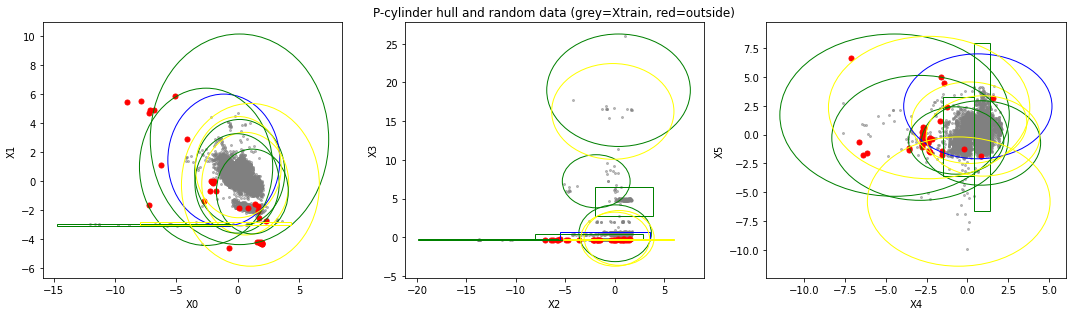

In [45]:
# Code to draw the hull in three 2D projections, using only non-redundant domains
fig = plt.figure(figsize=(15,4.5))
idx = [[0,1],[2,3],[4,5]]

for iax in range(3):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(131 + iax)
    ax.set_xlabel('X'+str(idx1))
    ax.set_ylabel('X'+str(idx2))
    ax.scatter(Xtrain[:,idx1], Xtrain[:,idx2], s=4, c='grey', alpha=0.5)
#    ax.scatter(indomain_Xtest[:,idx1], indomain_Xtest[:,idx2], s=25, c='green')
    ax.scatter(exdomain_Xtest[:,idx1], exdomain_Xtest[:,idx2], s=25, c='red')
    for k in range(train_hull.n_spheres):
        if train_hull.spheres[k].used:
            cyl, rect = rcs.pcylinder_patch(idx1, idx2, train_hull.spheres[k].center, train_hull.spheres[k].radius,
                                            train_hull.spheres[k].compact_dims, train_hull.spheres[k].compact_ranges, 
                                            color=clus_cols[k])
            ax.add_patch(cyl)
    if iax == 1:
        ax.set_title('P-cylinder hull and random data (grey=Xtrain, red=outside)')
fig.tight_layout()        

The classification results are not much worse for ex-domain data. However, the decision boundary drawn by the Random Forest for the training data only separates "high-efficiency" data from "low-efficiency" data, so we expect it to be static over time.

### Regression results: in-domain vs ex-domain data

In [46]:
indomain_ztest = ztest[inside]
exdomain_ztest = ztest[np.invert(inside)]
indomain_zpred = rmodel.predict(indomain_Xtest)
exdomain_zpred = rmodel.predict(exdomain_Xtest)
print('In-domain MAE:', metrics.mean_absolute_error(indomain_ztest,indomain_zpred))
print('Ex-domain MAE:', metrics.mean_absolute_error(exdomain_ztest,exdomain_zpred))

In-domain MAE: 1.190862628862619
Ex-domain MAE: 4.207309570072725


The regression results are much worse for ex-domain data, as expected. 
For in-domain data, let's see if prediction quality is related to the density of the p-sphere containing the data point.

P-sphere ID, P-sphere density
13 0.0016561756729044708
18 0.006204233347445596
11 0.019953507534042108
0 0.04747842114105988
1 0.05018872187543658
17 0.06480333485141974


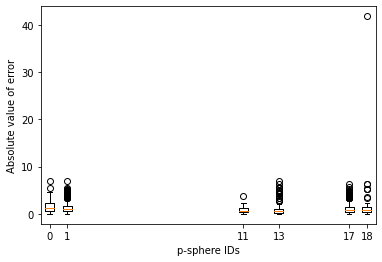

In [47]:
def find_best_density(vector, hull):
    containing_spheres = hull.find_containing_spheres(vector)
    densities = [hull.spheres[s].ndata / hull.spheres[s].pcylinder_vol for s in containing_spheres]
    best_density = max(densities)
    best_sphere = containing_spheres[densities.index(best_density)]
    return best_sphere, best_density

data_spheres = [find_best_density(row,train_hull) for row in indomain_Xtest]
densities = np.array([x[1] for x in data_spheres])
spheres = np.array([x[0] for x in data_spheres])
errors = np.abs(indomain_zpred-indomain_ztest)

vectors = []
densities = []
ids = []
for s in set(spheres):
    srows = np.where(spheres==s)[0]
    vectors.append(errors[srows])
    densities.append(train_hull.spheres[s].ndata / train_hull.spheres[s].pcylinder_vol)
    ids.append(s)
order = np.array(densities).argsort()
plt.boxplot([vectors[i] for i in order], positions=[ids[i] for i in order]);
plt.xlabel('p-sphere IDs')
plt.ylabel('Absolute value of error')

print('P-sphere ID, P-sphere density')
for i in order:
    print(ids[i], densities[i])

We can see that the prediction quality is not closely related to the p-sphere density. Outlier errors are found in all 6 p-spheres, with densities ranging from 0.0016 to 0.0648.

For ex-domain data, we can ask whether the prediction quality is related to distance from the closest p-cylinder. Note that the
method `psphere_distances` gives the distances to all p-spheres in the hull, whether they are masked or not. It is possible that
an ex-domain vector is actually inside one of the masked p-spheres, so here to get the distances from the hull, I select only the columns corresponding to spheres that are used.

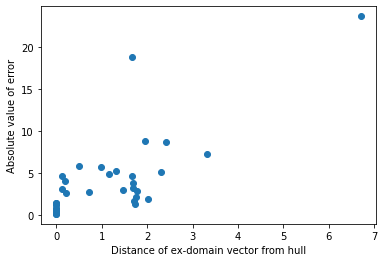

In [48]:
distances = train_hull.psphere_distances(exdomain_Xtest)
shortest_distances = np.min(distances[:,used_spheres], axis=1)
errors = np.abs(exdomain_zpred-exdomain_ztest)
plt.scatter(shortest_distances, errors)
plt.xlabel('Distance of ex-domain vector from hull')
plt.ylabel('Absolute value of error');

## Conclusion

This notebook has demonstrated a new approach to explainable and trusted AI that is suitable for traditional machine learning applications, where a predictive model is trained on historical data then enters production to immediately begin processing
new data. Rather than evaluating the model's overall performance and retraining periodically, I propose to explicitly model the
high-dimensional domain of the training dataset, and develop a supervision layer that raises a warning when the model is asked
for a prediction outside this domain. 

In this way the end users can receive __early warning of data drift and avoid using ex-domain predictions__, which are likely to be less reliable. This self-awareness on the part of a machine learning model also builds confidence that it understands the limits of its own training data. The simple machine learning application demonstrated at the end of the notebook confirms that ex-domain data are likely to have larger errors for a regression problem.

Like most clustering and segmentation algorithms, creating a good model for the training dataset's domain now requires human supervision. Visualizing high-dimensional data is challenging at the best of times, but the `refine_cluster_set` module provides tools to help us understand which sub-domains are relatively compact, so that a p-sphere boundary is a good approximation, and
which sub-domains are sparse, extended or low-dimensional. All ideas for automating the process on building a hull are welcome.

In [49]:
%watermark -u -n -t -z

last updated: Sat Nov 14 2020 22:26:15 Europe de l?Ouest
